In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))

In [5]:
target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)

In [7]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count', 'adj_fire_bcount']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

In [16]:
target_df.shape

(47388, 190)

### Perform PCA to see if we have any latent factors

In [29]:
X_features = target_df.copy()
for y in Y_cols + non_mod_cols:
    try:
        X_features.drop(y, inplace = True, axis =1)
    except:
        pass

In [30]:
X_features_scaled = scale(X_features)

In [31]:
pca = PCA()
pca_x = pca.fit(X_features_scaled)

In [26]:
pca_x.explained_variance_ratio_[0:20]

array([0.27543568, 0.15182484, 0.09592854, 0.08215558, 0.07373818,
       0.05016751, 0.03466626, 0.02746981, 0.02145478, 0.01922165,
       0.01584111, 0.01406854, 0.01325272, 0.01265155, 0.01151124,
       0.0092304 , 0.00817405, 0.00735119, 0.00678612, 0.00625473])

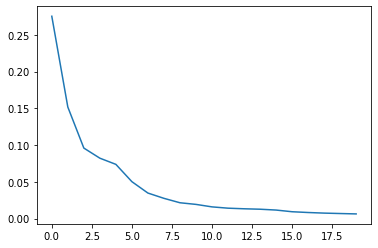

In [25]:
plt.plot(pca_x.explained_variance_ratio_[0:20])

In [24]:
pca_x.components_.shape

(170, 170)

In [44]:
pca_df = pd.DataFrame(pca_x.components_[0:20,].transpose(), columns = ["PC{}".format(i+1) for i in range(20)], \
                      index = X_features.columns)

In [45]:
pca_df.to_csv(os.path.join(data_dir, 'model_outputs/PCA_components_scaled.csv'))

### Transform

In [63]:
X_features_pca = pd.DataFrame(pca_x.transform(X_features_scaled), columns = X_features.columns)
X_features_pca['YEAR'] = target_df['YEAR']
X_train_pca = X_features_pca[X_features_pca['YEAR']< 2016]
X_test_pca = X_features_pca[X_features_pca['YEAR']>=2016]
Y_train_pca = target_df[target_df['YEAR']<2016]['Y_bin_new_fire_month']
Y_test_pca = target_df[target_df['YEAR']>=2016]['Y_bin_new_fire_month']

### Try a model on the top 20 features

In [64]:
cs = [10**i for i in range(-4, 2)] 

In [65]:
LR_pca_bin = {}
LR_pca_score = {}
LR_pca_preds = {}
LR_pca_auc = {}
LR_pca_max_auc_ind = {}
for i in np.arange(10, 30, 5):
    LR_pca_bin[i] = {}
    LR_pca_score[i] = {}
    LR_pca_preds[i] = {}
    LR_pca_auc[i] = []
    for c in cs:
        LR_pca_bin[i][c] = LogisticRegression(C = c, class_weight = 'balanced').fit(X_train_pca.iloc[:,0:i], Y_train_pca)
        LR_pca_score[i][c] = LR_pca_bin[i][c].predict_proba(X_test_pca.iloc[:,0:i])[:,1]
        LR_pca_preds[i][c] = LR_pca_bin[i][c].predict(X_test_pca.iloc[:,0:i])
        ##Find best feature # + regularization combo
        fpr, tpr, thresholds = roc_curve(Y_test_pca, LR_pca_score[i][c])
        LR_pca_auc[i].append(auc(fpr, tpr))
    LR_pca_max_auc_ind[i] = LR_pca_auc[i].index(np.max(LR_pca_auc[i]))
print(LR_pca_max_auc_ind)

{10: 0, 15: 1, 20: 1, 25: 1}


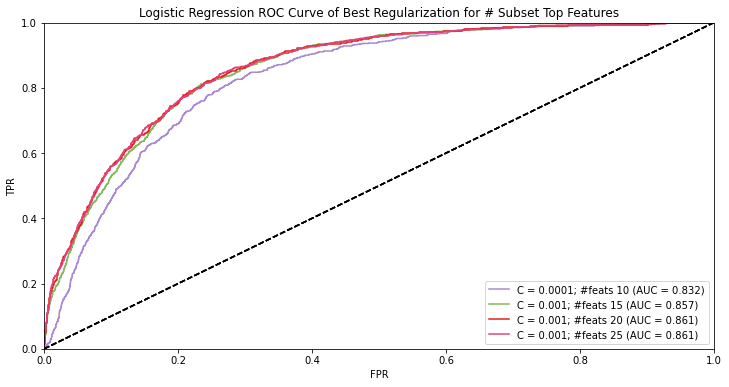

In [66]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (12,6))
for i in np.arange(10, 30, 5):
    c = cs[LR_pca_max_auc_ind[i]]
    fpr, tpr, thresholds = roc_curve(Y_test_pca, LR_pca_score[i][c])
    roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    col = (np.random.rand(), np.random.rand(), np.random.rand())

    #plot current model ROC curve
    plt.plot(fpr, tpr, color = col, label = f"C = {c}; " + f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Logistic Regression ROC Curve of Best Regularization for # Subset Top Features')
    plt.legend(loc="lower right")
plt.show()

In [70]:
cm = pd.DataFrame(confusion_matrix(Y_test_pca, LR_pca_preds[20][0.001], normalize = 'true'), columns = ['0', '1'],\
                  index = ['0','1'])
print(cm)

          0         1
0  0.685395  0.314605
1  0.116220  0.883780
